In [18]:
import os, yaml, sys
from sklearn.cluster import KMeans
import torch
from torchvision import models,datasets, transforms
import numpy as np
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from dadapy import data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_layer_out_shape
from parallel.parallel_funcs import print_wise
from experiments.utils import project_onto_PCs, project_onto_CCs
from sampling.sampling_methods import multistage_kmeans, assign_clusters_in_batches, subset_loader, sample_cluster_wise
from sampling.utils import features_sampling
from torch.utils.data import DataLoader, Subset
from alignment.utils import get_usual_transform, get_transform_to_show
from pref_viewing.utils import plot_imgs

In [2]:
def plot_kmeans_clusters(X, centers, final_lbl):
    """Plot the KMeans clusters with optional point labels."""
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    import torch

    # PCA if needed
    if X.shape[1] > 2:
        X_cpu = X
        pca = PCA(n_components=2).fit(X_cpu)
        X_pca = pca.transform(X_cpu)
        X = torch.from_numpy(X_pca)

        centers = torch.from_numpy(pca.transform(centers))
        
    # compute labels (nearest centroid index for each point)
    dists = torch.cdist(X, centers)
    labels = final_lbl #.cpu().numpy()
    print(X.shape)
    print(labels.shape)
    # plot points colored by cluster
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='tab10', alpha=0.7)
    

    # plot centers
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, marker='x')
    plt.title("KMeans Clusters")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

In [3]:
model_name1 = "alexnet"; model_name2 = "vit_b_16"; 
target_layer1 = "features.0"; target_layer2 = "encoder.layers.encoder_layer_2.add_1"
pooling="PC_pool"

In [4]:
d1, d2 = project_onto_CCs(model_name1, model_name2, target_layer1, target_layer2, pooling, 100, paths)

In [5]:
# do kmeans with n_clusters=35
n_samples = d1.shape[0]
max_n_clusters = n_samples//100
n_clusters_per_level = [max_n_clusters // (2 ** i) for i in range(4)]
print(n_clusters_per_level)

[491, 245, 122, 61]


In [6]:
centers, labels = multistage_kmeans(d1, n_clusters_per_level, init='k-means++', max_iter=1000, tol=1e-5, n_init=10)

16:25:10 - Levels: 4 | Clusters per level: [491, 245, 122, 61]
16:25:10 - --- Level 1/4: Clustering into 491 clusters ---
16:25:10 - Data shape: (49152, 100)
16:26:02 - --- Level 2/4: Clustering into 245 clusters ---
16:26:02 - Data shape: (491, 100)
16:26:05 - --- Level 3/4: Clustering into 122 clusters ---
16:26:05 - Data shape: (245, 100)
16:26:06 - --- Level 4/4: Clustering into 61 clusters ---
16:26:06 - Data shape: (122, 100)


In [7]:
C = centers[-1]
final_labels = assign_clusters_in_batches(d1, C, batch_size=1000)

torch.Size([49152, 2])
(49152,)


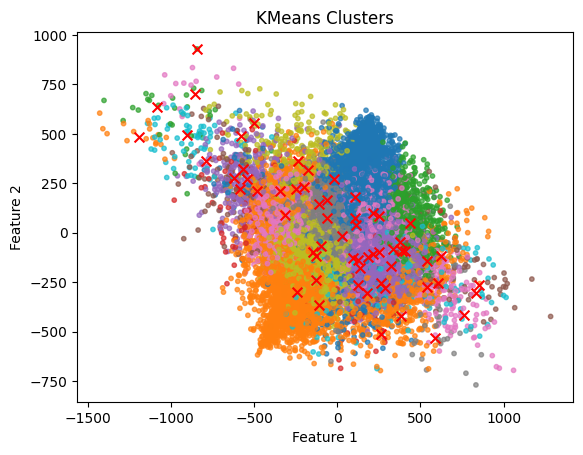

In [8]:
plot_kmeans_clusters(d1, centers[-1], final_labels)

In [11]:
representatives = sample_cluster_wise(final_labels, 1)
print(representatives)

[24645 43264   178 40303   130  2046 20579 42203 20993 43466   276  4354
 29290 19453 26570 30556  5396 46819 40947 24977 25573 42716 40238 22284
 18563 36293 16696 15928  5402  1080 27173 48302 44298  6155 35485 30263
 47513   632  5358 32067 10927 44671 31187 37969 31643 42485 43352 11116
 43693 39526 32549 49104 47341 36198 47422   127 46757 43402 38474 23526
 32967]


In [12]:
imagenet_val_path = f"{paths['data_path']}/imagenet/val"
batch_size = 1
loader_kmeans = subset_loader(imagenet_val_path, representatives, batch_size, shuffle=True, to_show=False)
loader_kmeans_to_show = subset_loader(imagenet_val_path, representatives, batch_size, shuffle=True, to_show=True)

random_idx = np.random.choice(49152, len(representatives), replace=False) #n_clusters_per_level[-1])

loader_random = subset_loader(imagenet_val_path, random_idx, batch_size, shuffle=True, to_show=False)
loader_random_to_show = subset_loader(imagenet_val_path, random_idx, batch_size, shuffle=True, to_show=True)


/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


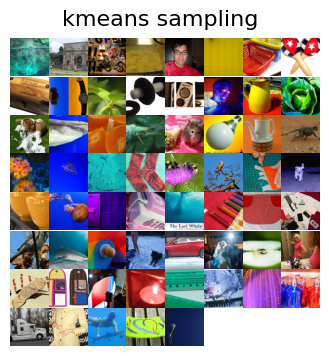

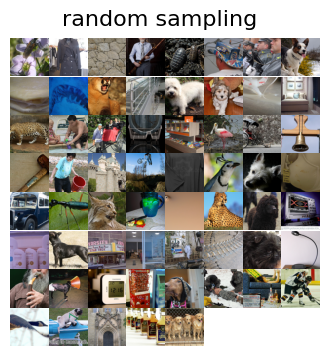

In [13]:
img_list = []
for img, _ in loader_kmeans_to_show:
    img = np.squeeze(img).permute(1,2,0)
    img_list.append(img)
a = plot_imgs(img_list, title = "kmeans sampling", square_size=4)

r_img_list = []

for img, _ in loader_random_to_show:
    img = np.squeeze(img).permute(1,2,0)
    r_img_list.append(img)
a = plot_imgs(r_img_list, title = "random sampling", square_size=4)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_network = "resnet50"
test_model_cls = getattr(models, test_network)
test_model = test_model_cls(pretrained=True).to(device).eval()
test_layer = "conv1"
test_feature_extractor = create_feature_extractor(test_model, return_nodes=[test_layer]).to(
    device
)
tot_neurons = np.prod(get_layer_out_shape(test_feature_extractor, test_layer))
neurons_perc = 20
rand_neu_num = int(tot_neurons*neurons_perc/100)
random_neu_idx = np.random.choice(tot_neurons, rand_neu_num, replace=False)

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
all_acts_kmeans = features_sampling(loader_kmeans, test_feature_extractor, test_layer, random_neu_idx)
all_acts_rand = features_sampling(loader_random, test_feature_extractor, test_layer, random_neu_idx)

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


16:29:02 - starting batch 1
16:29:02 - starting batch 2
16:29:02 - starting batch 3
16:29:02 - starting batch 4
16:29:02 - starting batch 5
16:29:02 - starting batch 6
16:29:02 - starting batch 7
16:29:02 - starting batch 8
16:29:02 - starting batch 9
16:29:02 - starting batch 10
16:29:02 - starting batch 11
16:29:02 - starting batch 12
16:29:02 - starting batch 13
16:29:02 - starting batch 14
16:29:02 - starting batch 15
16:29:02 - starting batch 16
16:29:02 - starting batch 17
16:29:02 - starting batch 18
16:29:02 - starting batch 19
16:29:02 - starting batch 20
16:29:02 - starting batch 21
16:29:02 - starting batch 22
16:29:02 - starting batch 23
16:29:02 - starting batch 24
16:29:02 - starting batch 25
16:29:02 - starting batch 26
16:29:02 - starting batch 27
16:29:02 - starting batch 28
16:29:02 - starting batch 29
16:29:02 - starting batch 30
16:29:02 - starting batch 31
16:29:02 - starting batch 32
16:29:02 - starting batch 33
16:29:02 - starting batch 34
16:29:02 - starting bat

variance : 
 kmeans :  6.094507 
 random : 2.6282642
ID : 
 kmeans :  14.910023289636737 
 random : 19.770335926229166


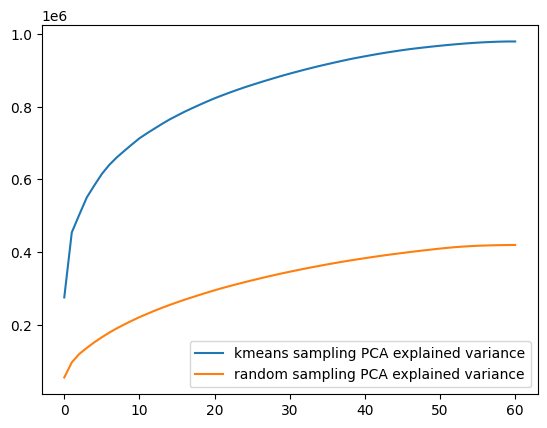

In [24]:
_data_kmeans = data.Data(all_acts_kmeans)
id_twoNN_kmeans, _, r = _data_kmeans.compute_id_2NN()

img_num = n_clusters_per_level[-1]
kmeans_pca = PCA(n_components=min(rand_neu_num, img_num))
kmeans_pca.fit(all_acts_kmeans)
kmeans_var = np.var(all_acts_kmeans)

_data_rand = data.Data(all_acts_rand)
id_twoNN_rand, _, r = _data_rand.compute_id_2NN()
rand_pca = PCA(n_components=min(rand_neu_num, img_num))
rand_pca.fit(all_acts_rand)
rand_var = np.var(all_acts_rand)


print("variance : \n", "kmeans : ", kmeans_var, "\n random :",  rand_var)
print("ID : \n", "kmeans : ", id_twoNN_kmeans, "\n random :",  id_twoNN_rand)
plt.plot(range(min(rand_neu_num, img_num)), np.cumsum(kmeans_pca.explained_variance_), label="kmeans sampling PCA explained variance")
plt.plot(range(min(rand_neu_num, img_num)), np.cumsum(rand_pca.explained_variance_), label="random sampling PCA explained variance")
plt.legend()

In [105]:
def mcmc_distant_sampling_numpy(X, n_samples, beta=1.0, seed=None):
    """
    MCMC sampler that favors distant points in a NumPy dataset.

    Args:
        X (np.ndarray): Data matrix (N, D)
        n_samples (int): Number of points to sample
        beta (float): Controls sharpness of distance preference (larger = stronger bias)
        seed (int, optional): Random seed

    Returns:
        indices (list): Indices of sampled points in X
    """
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    indices = []

    # Start from random point
    current_idx = rng.integers(N)
    indices.append(current_idx)

    while len(indices) < n_samples:
        # propose a random new index
        proposal_idx = rng.integers(N)

        # distance from proposed point to already chosen ones
        dists = np.linalg.norm(X[proposal_idx][None, :] - X[indices], axis=1)
        min_dist = dists.min()

        # distance of current point to set
        curr_dists = np.linalg.norm(X[current_idx][None, :] - X[indices], axis=1)
        curr_min_dist = curr_dists.min()

        # acceptance probability (Metropolis–Hastings)
        accept_prob = min(1.0, np.exp(beta * (min_dist - curr_min_dist)))

        # accept or reject
        if rng.random() < accept_prob:
            current_idx = proposal_idx
            indices.append(current_idx)

    return indices

In [109]:
n_samples = n_clusters_per_level[-1]
mcmc_idx = mcmc_distant_sampling_numpy(d1, n_samples, beta=1.0, seed=None)

/var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T/ipykernel_8213/3591188629.py:35: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1.0, np.exp(beta * (min_dist - curr_min_dist)))


In [110]:
loader_mcmc = subset_loader(imagenet_val_path, mcmc_idx, batch_size, shuffle=True, to_show=False)
loader_mcmc_to_show = subset_loader(imagenet_val_path, mcmc_idx, batch_size, shuffle=True, to_show=True)

In [113]:
all_acts_mcmc = features_sampling(loader_mcmc, test_feature_extractor, test_layer, random_neu_idx)

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [25]:
_data_mcmc = data.Data(all_acts_mcmc)
id_twoNN_mcmc, _, r = _data_mcmc.compute_id_2NN()
mcmc_pca = PCA(n_components=min(rand_neu_num, img_num))
mcmc_pca.fit(all_acts_mcmc)
mcmc_var = np.var(all_acts_mcmc)

NameError: name 'all_acts_mcmc' is not defined